# Creating Watermarked Images

In [ ]:
!pip install -r requirements.txt

In [1]:
import os
import math
import random

import cv2
import kagglehub
import numpy as np
import pandas as pd
from PIL import Image

# set constants
SEED = 19
CLASSES_NO = 37

# make the operations deterministic
random.seed(SEED)
np.random.seed(SEED)

In [2]:
def read_images_dataset(images_path):
    image_files = [
        f for f in os.listdir(images_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ]
    image_data = []

    for image_file in image_files:
        image_path = os.path.join(images_path, image_file)

        img = Image.open(image_path)

        image_data.append(
            {"image_name": image_file, "image_path": image_path, "image_size": img.size}
        )

    return pd.DataFrame(image_data)

## [The Oxford-IIIT Pet Dataset](https://www.kaggle.com/datasets/tanlikesmath/the-oxfordiiit-pet-dataset)

We need to resize the images if the Oxford-IIIT Pet dataset does not match the ones required for the image classifier. We plan to use either Tiny-Vit 5M or MobileViT-XXS 1.3M for image classification. Both of these models use images of 224x224 pixels.

In [3]:
def load_oxford_pet_dataset():
    return kagglehub.dataset_download("tanlikesmath/the-oxfordiiit-pet-dataset")

In [4]:
def read_oxford_pet_dataset():
    path = load_oxford_pet_dataset()
    images_path = f"{path}/images"
    return read_images_dataset(images_path)


oxford_pet_dataset = read_oxford_pet_dataset()
oxford_pet_dataset.head(5)

,image_name,image_path,image_size
0,Abyssinian_1.jpg,/home/jovyan/.cache/kagglehub/datasets/tanlike...,"(600, 400)"
1,Abyssinian_10.jpg,/home/jovyan/.cache/kagglehub/datasets/tanlike...,"(375, 500)"
2,Abyssinian_100.jpg,/home/jovyan/.cache/kagglehub/datasets/tanlike...,"(394, 500)"
3,Abyssinian_101.jpg,/home/jovyan/.cache/kagglehub/datasets/tanlike...,"(450, 313)"
4,Abyssinian_102.jpg,/home/jovyan/.cache/kagglehub/datasets/tanlike...,"(500, 465)"


In [5]:
def resize_image(image_path, dim):
    image = Image.open(image_path)
    if image.mode != "RGB":
        image = image.convert("RGB")
    new_size = (dim, dim)
    resized_image = image.resize(new_size)
    return resized_image

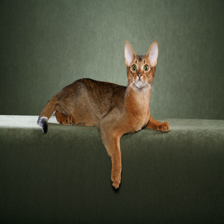

In [6]:
resize_image(oxford_pet_dataset["image_path"][0], 224)

### Split the dataset into trainval-test folds

This split is taken from [here](https://www.kaggle.com/datasets/julinmaloof/the-oxfordiiit-pet-dataset) and is the one recommended by the [authors](https://www.robots.ox.ac.uk/~vedaldi/assets/pubs/parkhi12cat.pdf). Additionally, add the class information to each image.

In [7]:
oxford_pet_dataset["image_name"] = oxford_pet_dataset["image_name"].map(
    lambda x: x.replace(".jpg", "")
)
oxford_pet_dataset = oxford_pet_dataset.set_index("image_name")
oxford_pet_dataset

,image_path,image_size
image_name,,
Abyssinian_1,/home/jovyan/.cache/kagglehub/datasets/tanlike...,"(600, 400)"
Abyssinian_10,/home/jovyan/.cache/kagglehub/datasets/tanlike...,"(375, 500)"
Abyssinian_100,/home/jovyan/.cache/kagglehub/datasets/tanlike...,"(394, 500)"
Abyssinian_101,/home/jovyan/.cache/kagglehub/datasets/tanlike...,"(450, 313)"
Abyssinian_102,/home/jovyan/.cache/kagglehub/datasets/tanlike...,"(500, 465)"
...,...,...
yorkshire_terrier_95,/home/jovyan/.cache/kagglehub/datasets/tanlike...,"(500, 332)"
yorkshire_terrier_96,/home/jovyan/.cache/kagglehub/datasets/tanlike...,"(500, 335)"
yorkshire_terrier_97,/home/jovyan/.cache/kagglehub/datasets/tanlike...,"(335, 500)"


In [8]:
test_images = pd.read_csv("./data/test.txt", delimiter=" ", header=None)[[0, 1]]
test_images["fold"] = "test"

trainval_images = pd.read_csv("./data/trainval.txt", delimiter=" ", header=None)[[0, 1]]
trainval_images["fold"] = "trainval"

dataset_folds = (
    pd.concat([test_images, trainval_images])
    .rename({0: "image_name", 1: "class"}, axis=1)
    .set_index("image_name")
)
dataset_folds

,class,fold
image_name,,
Abyssinian_201,1,test
Abyssinian_202,1,test
Abyssinian_204,1,test
Abyssinian_205,1,test
Abyssinian_206,1,test
...,...,...
yorkshire_terrier_187,37,trainval
yorkshire_terrier_188,37,trainval
yorkshire_terrier_189,37,trainval


In [9]:
pet_dataset_info = oxford_pet_dataset.join(dataset_folds, on="image_name")
pet_dataset_info = pet_dataset_info.dropna()
pet_dataset_info

,image_path,image_size,class,fold
image_name,,,,
Abyssinian_1,/home/jovyan/.cache/kagglehub/datasets/tanlike...,"(600, 400)",1.0,trainval
Abyssinian_10,/home/jovyan/.cache/kagglehub/datasets/tanlike...,"(375, 500)",1.0,trainval
Abyssinian_100,/home/jovyan/.cache/kagglehub/datasets/tanlike...,"(394, 500)",1.0,trainval
Abyssinian_101,/home/jovyan/.cache/kagglehub/datasets/tanlike...,"(450, 313)",1.0,trainval
Abyssinian_102,/home/jovyan/.cache/kagglehub/datasets/tanlike...,"(500, 465)",1.0,trainval
...,...,...,...,...
yorkshire_terrier_95,/home/jovyan/.cache/kagglehub/datasets/tanlike...,"(500, 332)",37.0,test
yorkshire_terrier_96,/home/jovyan/.cache/kagglehub/datasets/tanlike...,"(500, 335)",37.0,test
yorkshire_terrier_97,/home/jovyan/.cache/kagglehub/datasets/tanlike...,"(335, 500)",37.0,test


In [10]:
def save_resize_oxford_pet_dataset(original_dataset, fold):
    output_dir = f"./data/resized_images/{fold}"

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for _, row in original_dataset.iterrows():
        input_image_path = row["image_path"]
        resized_image = resize_image(input_image_path, 224)

        output_image_path = os.path.join(output_dir, row["image_name"])
        resized_image.save(output_image_path + ".jpg")

    return output_dir


trainval_data = pet_dataset_info[pet_dataset_info["fold"] == "trainval"].reset_index()
resized_dataset_dir_path = save_resize_oxford_pet_dataset(trainval_data, "trainval")
trainval_data["image_path"] = trainval_data["image_path"].map(
    lambda x: f"./data/resized_images/trainval/" + x.split("/")[-1]
)

test_data = pet_dataset_info[pet_dataset_info["fold"] == "test"].reset_index()
resized_dataset_dir_path = save_resize_oxford_pet_dataset(test_data, "test")
test_data["image_path"] = test_data["image_path"].map(
    lambda x: f"./data/resized_images/test/" + x.split("/")[-1]
)

In [11]:
pet_dataset_info = (
    pd.concat([trainval_data, test_data]).set_index("image_name").drop("image_size", axis=1)
)
pet_dataset_info.to_csv("./data/pet_dataset_info.csv")
pet_dataset_info

,image_path,class,fold
image_name,,,
Abyssinian_1,./data/resized_images/trainval/Abyssinian_1.jpg,1.0,trainval
Abyssinian_10,./data/resized_images/trainval/Abyssinian_10.jpg,1.0,trainval
Abyssinian_100,./data/resized_images/trainval/Abyssinian_100.jpg,1.0,trainval
Abyssinian_101,./data/resized_images/trainval/Abyssinian_101.jpg,1.0,trainval
Abyssinian_102,./data/resized_images/trainval/Abyssinian_102.jpg,1.0,trainval
...,...,...,...
yorkshire_terrier_95,./data/resized_images/test/yorkshire_terrier_9...,37.0,test
yorkshire_terrier_96,./data/resized_images/test/yorkshire_terrier_9...,37.0,test
yorkshire_terrier_97,./data/resized_images/test/yorkshire_terrier_9...,37.0,test


## [QMUL-OpenLogo Dataset](https://hangsu0730.github.io/qmul-openlogo/)
We need to edit the images in this dataset by converting them to grayscale, removing the background and applying a specified transparency.

In [12]:
qmul_openlogo_dataset = read_images_dataset("./data/qmul_openlogo_dataset")

# shuffle the rows so that we can take a random subset
qmul_openlogo_dataset = qmul_openlogo_dataset.sample(frac=1, random_state=SEED).reset_index(
    drop=True
)


qmul_openlogo_dataset.head(5)

,image_name,image_path,image_size
0,espn.jpg,./data/qmul_openlogo_dataset/espn.jpg,"(405, 124)"
1,mini.jpg,./data/qmul_openlogo_dataset/mini.jpg,"(1600, 674)"
2,head.jpg,./data/qmul_openlogo_dataset/head.jpg,"(400, 263)"
3,redbull.jpg,./data/qmul_openlogo_dataset/redbull.jpg,"(149, 60)"
4,intel.jpg,./data/qmul_openlogo_dataset/intel.jpg,"(268, 188)"


In [13]:
def convert_to_grayscale(image_path):
    image = Image.open(image_path)
    return image.convert("LA")

In [14]:
def resize_logo(image, max_size):
    # resize an image to a maximum height or width by keeping the aspect ratio
    if image.size[0] > image.size[1]:
        new_size = (max_size, int(max_size * image.size[1] / image.size[0]))
    else:
        new_size = (int(max_size * image.size[0] / image.size[1]), max_size)

    resized_image = image.resize(new_size)

    return resized_image

In [15]:
def get_transpacency_mask(image_path, transparency):
    # a threshold is needed to separate the logo from the background
    image = cv2.imread(image_path, 0)

    # first, a Gaussian blur is applied to avoid rough edges
    blurred_image = cv2.GaussianBlur(image, (3, 3), 0)

    # then the threshold is found using the Otsu's binarization method
    _, thresholded = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # the background is set to 0 and the logo to the desired transparency
    thresholded = (255 - thresholded) // 255 * transparency
    mask = Image.fromarray(thresholded)

    return mask

In [16]:
def get_transparency_adjusted_logo(image_path, transparency_value):
    image = convert_to_grayscale(image_path)

    # mask the image to remove the background and change transparency
    transparency = int((1 - transparency_value) * 255)
    mask = get_transpacency_mask(image_path, transparency)
    image.putalpha(mask)

    image = image.convert("RGBA")
    image = resize_logo(image, 224)

    return image

## Creating the Final Dataset
Each logo will be applied on the host image at a random position with a random size, rotation and transparency. Considering the related work, each logo should be placed on multiple images and the logos included in the trainval and test sets should be disjoint. Because the dataset will be classified, we impose the constraint that each logo should be hosted by at least n images from each class. This will help in making sure the logos are distributed evenly across classes.

In [17]:
def get_logos(pet_dataset_info, qmul_openlogo_dataset, class_images_per_logo):
    trainval_logos_no = (
        math.floor(
            pet_dataset_info[pet_dataset_info["fold"] == "trainval"].shape[0]
            / CLASSES_NO
            / class_images_per_logo
        )
        + 1
    )

    test_logos_no = (
        math.floor(
            pet_dataset_info[pet_dataset_info["fold"] == "test"].shape[0]
            / CLASSES_NO
            / class_images_per_logo
        )
        + 1
    )

    trainval_logos = qmul_openlogo_dataset[:trainval_logos_no]["image_path"].to_list()
    test_logos = qmul_openlogo_dataset[trainval_logos_no : trainval_logos_no + test_logos_no][
        "image_path"
    ].to_list()

    return trainval_logos, test_logos


trainval_logos_path, test_logos_path = get_logos(pet_dataset_info, qmul_openlogo_dataset, 3)

In [18]:
def place_logo(image_path, logo_path):
    image = Image.open(image_path)

    tranparency_value = random.uniform(0.35, 0.6)
    logo = get_transparency_adjusted_logo(logo_path, tranparency_value)

    rotation = random.randint(-45, 45)
    logo = logo.rotate(rotation, expand=True).resize((224, 224))

    scaling_factor = random.uniform(0.6, 0.85)
    logo = logo.resize(
        (math.floor(logo.size[0] * scaling_factor), math.floor(logo.size[1] * scaling_factor))
    )

    position = (
        random.randint(0, image.size[0] - logo.size[0]),
        random.randint(0, image.size[1] - logo.size[1]),
    )
    image.paste(logo, position, logo)

    return image

In [19]:
def create_dataset_with_logos(fold, logos_path):
    pet_dataset_fold = pet_dataset_info[pet_dataset_info["fold"] == fold]
    output_dir = f"./data/images_with_logos/{fold}/"

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for logo_path in logos_path:
        images_for_logo = pet_dataset_fold.groupby("class").head(3)
        images_for_logo_paths = images_for_logo["image_path"].to_list()

        for image_for_logo_path in images_for_logo_paths:
            image_with_logo = place_logo(image_for_logo_path, logo_path)
            image_with_logo.save(output_dir + image_for_logo_path.split("/")[-1])

        pet_dataset_fold = pet_dataset_fold[~pet_dataset_fold.index.isin(images_for_logo.index)]

    assert pet_dataset_fold.shape[0] == 0, "Not all images have logos"


create_dataset_with_logos("trainval", trainval_logos_path)
create_dataset_with_logos("test", test_logos_path)

In [34]:
!python -m pip freeze > requirements.txt

In [35]:
!pip install -r requirements.txt --force

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/MaximeJumelle/ALEPython.git (to revision 286350ab674980a32270db2a0b5ccca1380312a7) to /tmp/pip-install-6wvft6rk/alepython_f520106ccf5341ac8ab18975edb54f43
  Running command git clone --filter=blob:none --quiet https://github.com/MaximeJumelle/ALEPython.git /tmp/pip-install-6wvft6rk/alepython_f520106ccf5341ac8ab18975edb54f43
  Running command git rev-parse -q --verify 'sha^286350ab674980a32270db2a0b5ccca1380312a7'
  Running command git fetch -q https://github.com/MaximeJumelle/ALEPython.git 286350ab674980a32270db2a0b5ccca1380312a7
  Resolved https://github.com/MaximeJumelle/ALEPython.git to commit 286350ab674980a32270db2a0b5ccca1380312a7
  Preparing metadata (setup.py) ... done
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl (12.8 MB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)